# R-SHAP Implementation

### Workspace Prep

In [2]:
import lstm_model as lm
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import shap
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger as TensorBoardLogger
import tensorboard


import numpy as np


C:\Users\alexander\anaconda3\envs\itcs_8156p\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Uncomment below to install missing modules

In [3]:
# pip install tensorboard

In [4]:
# pip install --ignore-installed PyYAML  # might be necessary to run before installing pytorch

In [5]:
# pip install pytorch-lightning

In [6]:
# pip install torch

### Load Pre-processing Utilities

In [6]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
# sys.path.insert(1, r'D:\Documents\GitHub\itcs-8156\utils')
sys.path.insert(1, r'H:\My Drive\SP23\ML\envs\gw2\utils')


from preprocessing import (market_prepro,
                           lstm_timeseries_feat_and_targ,
                           
)

### Load and Pre-processs Stock Data

In [65]:
class BasicLSTM(pl.LightningModule):

    def __init__(self, num_feat, num_hiddens, num_out, lr):
        '''
        num_feat - number of features input into the model
        '''
        super().__init__()
        self.num_feat = num_feat
        self.num_hiddens = num_hiddens
        self.num_out = num_out

        self.lr = lr

        shape_w1 = (num_hiddens,num_feat)
        shape_w2 = (num_hiddens,num_hiddens)
        
        mean = 0.0
        std = 1.0

        #the forget gate weights and bias 
        #(for f_t = sig(wf1 x_t + wf2 h_{t-1} + b_f))
        self.wf1 ,self.wf2, self.bf = self.initWeights(shape_w1, shape_w2, mean, std)

        #the input gate weights and bias
        #(for i_t = sig(wi1 x_t + wi2 h_{t-1} + b_i))
        self.wi1, self.wi2, self.bi = self.initWeights(shape_w1, shape_w2, mean, std) 
        #the output gate weights and bias
        #(for o_t = sig(wo1 x_t + wo2 h_{t-1} + b_o))
        self.wo1, self.wo2, self.bo = self.initWeights(shape_w1, shape_w2, mean, std)
        #the candidate context weights and bias
        #(for c^'_t = sig(wcc1 x_t + wcc2 h_{t-1} + bc_c))
        self.wcc1, self.wcc2, self.bcc = self.initWeights(shape_w1, shape_w2, mean, std)

        self.whq = nn.Parameter(torch.normal(mean=mean,
                                             std=std,
                                             size=(num_hiddens, num_out)),
                                requires_grad=True,
                                )
        self.bq = nn.Parameter(torch.tensor(0.0),
                        requires_grad=True,
                        )

        # print('wf1 \n', self.wf1.shape, '\n wf2 \n', self.wf2.shape, '\n bf \n', self.bf.shape)
        # print('wi1 \n', self.wi1.shape, '\n wi2 \n', self.wi2.shape, '\n bi \n', self.bi.shape)
        # print('wcc1 \n', self.wf1.shape, '\n wcc2 \n', self.wf2.shape, '\n bf \n', self.bcc.shape)
        # print('wo1 \n', self.wo1.shape, '\n wo2 \n', self.wo2.shape, '\n bo \n', self.bo.shape)

    def initWeights(self, shape_w1, shape_w2, mean, std):
        w1 = nn.Parameter(torch.normal(mean=mean,std=std, size=shape_w1),
                                requires_grad=True,
                                )
        w2 = nn.Parameter(torch.normal(mean=mean,std=std,size=shape_w2),
                                requires_grad=True,
                                )
        bias = nn.Parameter(torch.zeros(self.num_hiddens),
                                requires_grad=True,
                                )
        return w1, w2, bias


    def unit(self, val_in, long_mem, short_mem):
        '''
        INPUTS:
            val_in - input into this step of the unit x_t

            long_mem - the long term memory at this step

            short_mem - the short term memory at this step
        OUTPUTS:

        
        '''
        val_in = val_in.float()

        i_t = torch.sigmoid((self.wi1@val_in)+(self.wi2@short_mem)+(self.bi))

        f_t = torch.sigmoid((self.wf1@val_in)+(self.wf2@short_mem)+(self.bf))
        
        o_t = torch.sigmoid((self.wo1@val_in)+(self.wo2@short_mem)+(self.bo))

        cc_t = torch.tanh((self.wcc1@val_in)+(short_mem@short_mem)+(self.bcc))

        # print('f_t ', f_t)
        # print('i_t ', i_t)
        # print('cc_t ', cc_t)
        # print('o_t ', o_t)

        #update the long term memory (c_t)
        c_t = (f_t*long_mem) + (i_t*cc_t)

        #update the short term memory (h_t)
        h_t = o_t*torch.tanh(c_t)

        return [c_t, h_t]


    def forward(self, input):
        '''
        in order case input should be an array with multiple inputs for the model.
        The columns are the features and the rows are the days
        '''
        n_seq = np.shape(input)[-1]

        long_mem = torch.zeros(self.num_hiddens)
        short_mem = torch.zeros(self.num_hiddens)
        
        h_hist=np.zeros(n_seq+1)
        c_hist=np.zeros(n_seq+1)
        x_hist=np.zeros((input.shape[0], n_seq))

        h_hist[0] = short_mem
        c_hist[0] = long_mem

        

        for ii in range(0,n_seq):

            long_mem, short_mem = self.unit(input[:,ii], 
                                                    long_mem, 
                                                    short_mem,
                                                    )
            #?
            h_hist[ii+1] = short_mem.detach().numpy()
            c_hist[ii+1] = long_mem.detach().numpy()
            x_hist[:,ii] = input[:,ii].numpy()
        # print(short_mem, long_mem, h_hist, c_hist, x_hist)
        return short_mem, h_hist, c_hist, x_hist


    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_indx):

        input_i, label_i = batch
        output_i = self.forward(input_i[0])[0]

        loss = (output_i - label_i)**2

        self.log("training loss", loss, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i[0])[0]

        test_loss = (output_i - label_i)**2

        self.log("test_loss", test_loss, on_step=True, logger=True)


    def predict_step(self, batch, batch_idx, dataloader_idx=0):

        return self(batch)
    
    
    def makepred(self, dataset):
        y = []
        t = []

        h_hist=[]
        c_hist=[]
        x_hist=[]
        for ii in dataset:
            feat, lab = ii
            y_i, h_i, c_i, x_i = self.forward(feat)

            y_i = (y_i.detach().numpy())

            y.append(y_i)
            t.append(lab.numpy())
            h_hist.append(h_i)
            c_hist.append(c_i)
            x_hist.append(x_i)


        return y, t, h_hist, c_hist, x_hist

In [7]:
# st = "Stocks"
st = "ETFs"

#Input stock name
sn = "aadr" 
# f = r'D:\Desktop\College Spring 2023\machineLearning\project\coding\data'
f = r'H:\My Drive\stockMarket_data'
X_train, X_test, T_train, T_test = market_prepro(f,st,sn,False,splitdata=True, stdzr='minmax')

print(X_train.shape)
print(T_train.shape)
# X,T = market_prepro(f,st,sn,False,splitdata=False)

#number of days as features
day_feat = 2

#number of days to use as features
day_targ = 1
day_targ = day_targ - 1

# dl_train, ds_train = lstm_timeseries_feat_and_targ(X_train[['Open','Low']], T_train, 4, 1,None)
# dl_test, ds_test = lstm_timeseries_feat_and_targ(X_test[['Open','Low']], T_test, 4, 1,  None)

dl_train, ds_train = lstm_timeseries_feat_and_targ(X_train, T_train, day_feat, day_targ, [ 'Year', 'Month' ,'Day_date', 'Day'])
dl_test, ds_test = lstm_timeseries_feat_and_targ(X_test, T_test, day_feat, day_targ, [ 'Year', 'Month' ,'Day_date', 'Day'])


(1044, 11)
(1044,)


### Use LSTM on Stock Data

In [8]:
print(torch.version.cuda)

None


In [66]:
mdl_stock = lm.BasicLSTM(num_feat=7, num_hiddens=1, num_out=1, lr=0.01)
mdl_stock2 = BasicLSTM(num_feat=7, num_hiddens=1, num_out=1, lr=0.01)

In [78]:
a,b,c,d,e = mdl_stock2.makepred(ds_train)
# print(a,b,c,d,e)

In [13]:
logger = TensorBoardLogger("lightning_logs", name="market")

trainer = pl.Trainer(max_epochs=10,logger=logger) # with default learning rate, 0.001 (this tiny learning rate makes learning slow)
trainer.fit(mdl_stock, train_dataloaders=dl_train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Epoch 9: 100%|███████████████████████████████████████████████████████████| 1043/1043 [00:05<00:00, 189.85it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████| 1043/1043 [00:05<00:00, 189.46it/s, v_num=3]


In [14]:
trainer.test(mdl_stock,dataloaders=dl_test)

C:\Users\alexander\anaconda3\envs\itcs-8156\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████| 520/520 [00:01<00:00, 316.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.008795179920984319
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.008795179920984319}]

### Apply Shap

In [79]:
y_test, t_test, h_hist_test, c_hist_test, x_hist_test = mdl_stock2.makepred(ds_test)
y_train, t_train, h_hist_train, c_hist_train, x_hist_train = mdl_stock2.makepred(ds_train)

In [83]:
y_test, t_test, h_hist_test, c_hist_test, x_hist_test = mdl_stock2.makepred(ds_test)



In [1]:

for jj in range(len(x_hist_test)):
    for kk in range(day_feat+day_targ):
        shap_hist[jj,kk] = mdl_stock2.predict
        

NameError: name 'x_hist_test' is not defined

In [74]:
from sklearn.metrics import (mean_absolute_percentage_error,
                             r2_score,
)

# train_mape = mean_absolute_percentage_error(t_train, y_train)
# test_mape = mean_absolute_percentage_error(t_test, y_test)



# print('Training MAPE ', train_mape)
# print('Testing MAPE ', test_mape)

print('Training r2 ', r2_score(t_train, y_train) )
print('Testing r2 ', r2_score(t_test, y_test) )

Training r2  -1.5726111532435856
Testing r2  -3.9431549039450537


In [75]:
import matplotlib.pyplot as plt

def scatter_results(Y,T,title):
    plt.figure(figsize=(9,9))
    plt.scatter(Y,T)
    plt.xlabel('Model Prediction')
    plt.ylabel('True Value')
    plt.title(title)

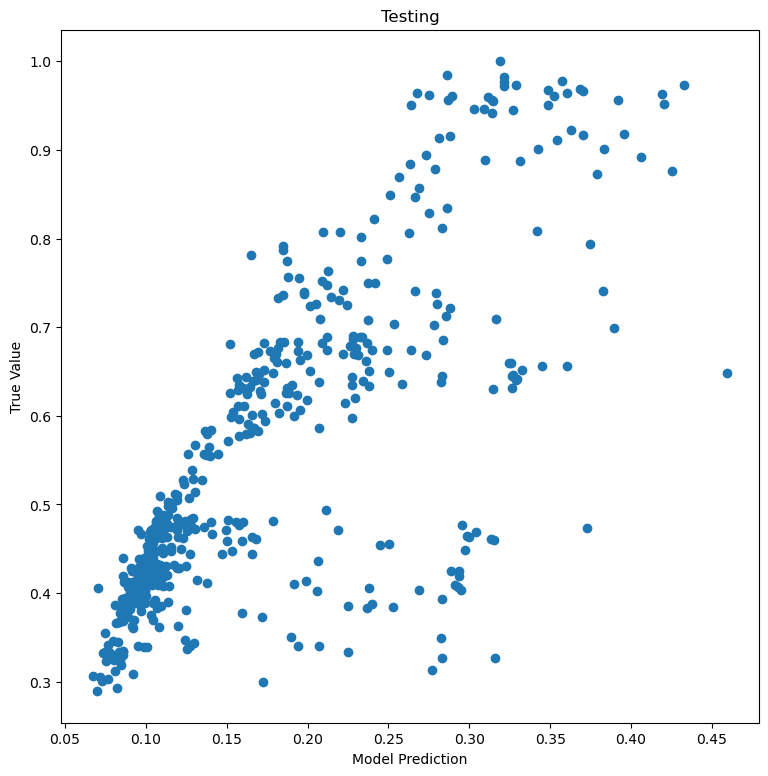

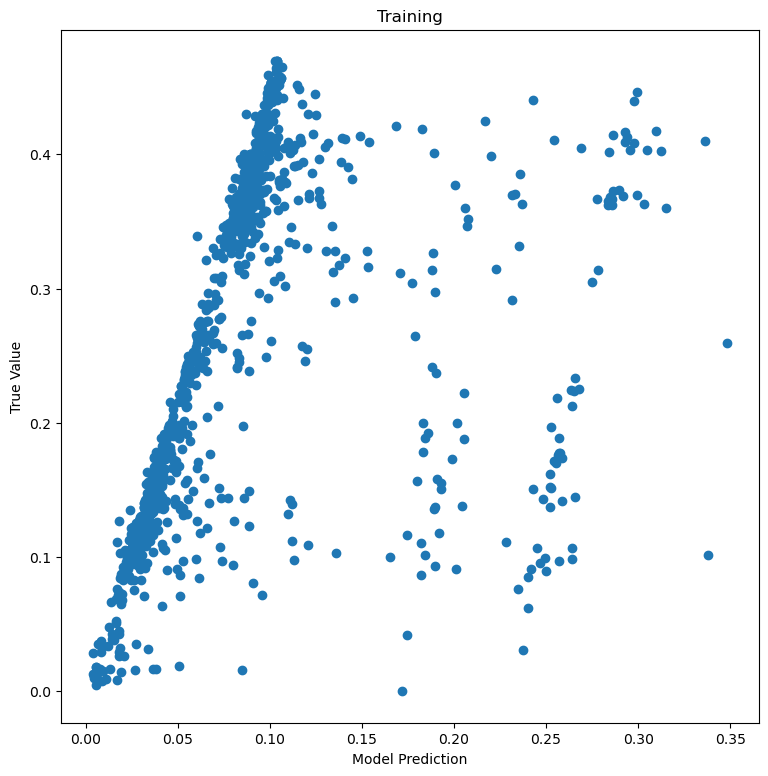

In [76]:
scatter_results(y_test, t_test, 'Testing')
scatter_results(y_train, t_train, 'Training')

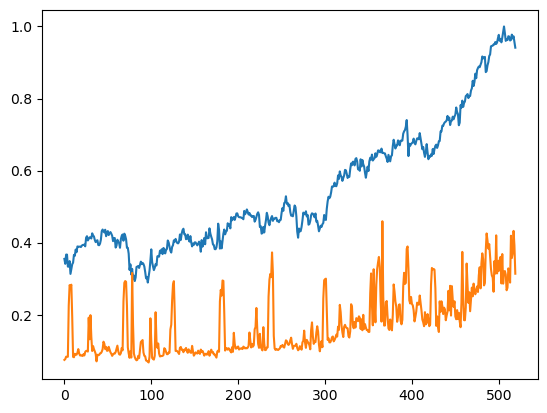

In [77]:
plt.plot(range(len(t_test)),t_test)
plt.plot(range(len(y_test)),y_test)